# A Finite Element Examples: Frame 05

This example is based on the frame03 example distributed with FEM.edu

This is a single story-single bay frame system.

## Load needed components

We need to add the local code to the path or python won't find FEM.edu

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

Now load the needed components of FEM.edu

In [2]:
from femedu.domain import *
from femedu.solver.NewtonRaphsonSolver import *
from femedu.elements.Frame2D import *
from femedu.materials.ElasticSection import *

## Build a model

In [3]:
# initialize a system model

B = 240.
H = 200.

E  = 29000.0

Ac = 20.0
Ic = 10.0

Af = 20.0
If = 10.0

w = 1.0

Ph = 0.00      # additional horizontal load per floor (imperfection)

# ========== setting global parameters ==============

target_load_level = 1.00
max_steps = 10
load_levels = np.linspace(0, target_load_level, max_steps)

# ========= build your structural model =============

model = System()
model.setSolver(NewtonRaphsonSolver())

x1 = 0.0
x2 = B
x3 = 2*B
x4 = 0.5*B
x5 = 1.5*B

y0 = 0.0
y1 = H 
y2 = 2 * H

# first column
X10 = Node(x1, y0)
X11 = Node(x1, y1)
X12 = Node(x1, y2)

# second column
X20 = Node(x2, y0)
X21 = Node(x2, y1)
X22 = Node(x2, y2)

# third column
X30 = Node(x3, y0)
X31 = Node(x3, y1)
X32 = Node(x3, y2)

# 4th (virtual) column
X41 = Node(x4, y1)
X42 = Node(x4, y2)

# 5th (virtuial) column
X51 = Node(x5, y1)
X52 = Node(x5, y2)

model.addNode(X10,X11,X12)
model.addNode(X20,X21,X22)
model.addNode(X30,X31,X32)
model.addNode(X41,X42)
model.addNode(X51,X52)

# columns

paramsCol   = {'E': E, 'A': Ac, 'I': Ic}

C10 = Frame2D(X10, X11, ElasticSection(paramsCol))
C11 = Frame2D(X11, X12, ElasticSection(paramsCol))

C20 = Frame2D(X20, X21, ElasticSection(paramsCol))
C21 = Frame2D(X21, X22, ElasticSection(paramsCol))

model += Frame2D(X30, X31, ElasticSection(paramsCol))
model += Frame2D(X31, X32, ElasticSection(paramsCol))

model.addElement(C10,C11, C20,C21)

# floors

paramsFloor = {'E': E, 'A': Af, 'I': If}

F11 = Frame2D(X11, X41, ElasticSection(paramsFloor))
F12 = Frame2D(X41, X21, ElasticSection(paramsFloor))
F13 = Frame2D(X21, X51, ElasticSection(paramsFloor))
F14 = Frame2D(X51, X31, ElasticSection(paramsFloor))

model.addElement(F11,F12,F13,F14)

F21 = Frame2D(X12, X42, ElasticSection(paramsFloor))
F22 = Frame2D(X42, X22, ElasticSection(paramsFloor))
F23 = Frame2D(X22, X52, ElasticSection(paramsFloor))
F24 = Frame2D(X52, X32, ElasticSection(paramsFloor))

model.addElement(F21,F22,F23,F24)

# fixities
X10.fixDOF('ux','uy')        # pin
X20.fixDOF('ux','uy','rz')   # fixed
X30.fixDOF('ux','uy')        # pin

# reference load
#Pcr = np.pi**2 * EI / L**2
model.resetLoad()            # size load vector and initialize
#model.addLoad(Xn, -Pcr, dof=0) # add a horizontal force (first dof only) ; remember C-style indexing: 0,1,...,(n-1)


# floor loading as distributed loads ...

F11.setDistLoad(-w)
F12.setDistLoad(-w)
F23.setDistLoad(-w)
F24.setDistLoad(-w)


# wind load ...

#X11.addLoad([Ph],['ux'])   # horizontal load


# show model information
#print(model)



## Path-Following and Stability Analysis

In [4]:


target_load_level = 0.10
max_steps = 10
load_levels = np.linspace(0, target_load_level, max_steps)

# initialize the analysis:
model.resetDisplacements()   # set U to all zeros
model.setLoadFactor(0.0)     # define a known equilibrium solution

model.startRecorder()        # not doing anything yet, but will do the data collection soon

detKt   = []
lambdas = []

# solve for all load_levels
for loadfactor in load_levels:

    # define node X2 as the controled node; downward direction is prescribed:
    model.setLoadFactor(loadfactor)
    model.solve(verbose=True)

    # stability check
    lambdas.append(model.loadfactor)
    detKt.append(model.solver.checkStability())

    # report results
    print('+')
    #model.report()

    print("\n=== next load level ===\n")
    

print(lambdas)
print(detKt)


norm of the out-of-balance force:   0.0000e+00
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.03379264486689718

+

=== next load level ===

norm of the out-of-balance force:   2.6766e+01
norm of the out-of-balance force:   7.0019e-01
norm of the out-of-balance force:   3.8632e-04
norm of the out-of-balance force:   2.5328e-07
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.03184240213712757

+

=== next load level ===

norm of the out-of-balance force:   2.6766e+01
norm of the out-of-balance force:   1.4243e+00
norm of the out-of-balance force:   1.6782e-03
norm of the out-of-balance force:   2.2462e-06
norm of the out-of-balance force:   1.0169e-08
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.02987637478306606

+

=== next load level ===

norm of the out-of-balance force:   2.6766e+01
norm of the out-of-balance force:   2.1738e+00
norm of the out-of-balance force:   4.1562e-03
norm of the out-of-balance force:   8.5223e-06
norm of the out-of-balance force:

In [5]:
#
# ==== check the current state of the model ===
#

#model.report()

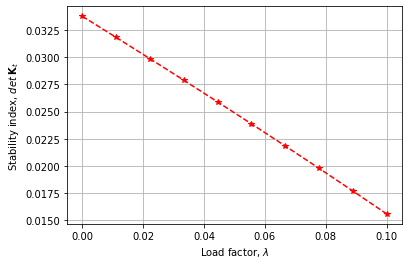

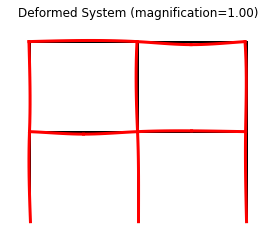

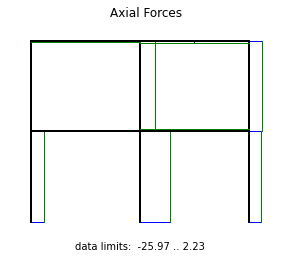

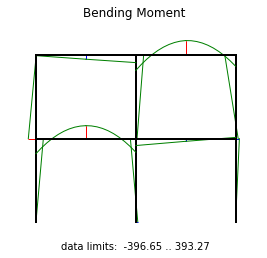

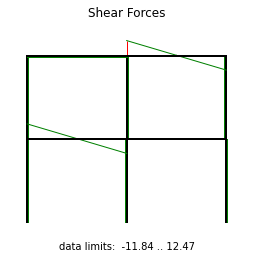

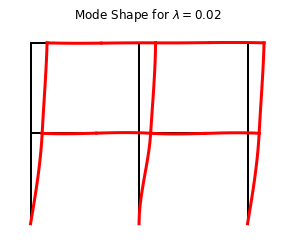

In [6]:
#
# ==== create some nice plots ===
#

plt.plot(lambdas,detKt,'--*r')
plt.grid(True)
plt.xlabel('Load factor, $ \lambda $')
plt.ylabel("Stability index, $ {det}\: {\\bf K}_t $")
plt.savefig("frame3_stability_check")
plt.show()

model.plot(factor=1.0, filename="frame5_deformed.png")

model.beamValuePlot("F", filename="frame5_force.png")
model.beamValuePlot("M", filename="frame5_moment.png")
model.beamValuePlot("V", filename="frame5_shear.png")

model.plotBucklingMode(factor=100., filename="frame5_buckling_mode0.png")


In [7]:
print(C20)

Frame2D: node 3 to node 4:
   material properties: ElasticSection(Material)({'E': 29000.0, 'A': 20.0, 'I': 10.0, 'nu': 0.0, 'fy': 1e+30})  strain:{'axial': -4.4776710968478534e-05, 'flexure': 0.0}   stress:{'axial': -25.97049236171755, 'flexure': 0.0}  
   internal forces: f0=-25.97 V0=1.25 M0=-52.92 fl=-25.97 Vl=1.25 Ml=141.75 Pw=0.00 Mw=0.00
